## Imports and Functions

In [54]:
import pandas as pd
import cv2
import os
import time, copy

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


In [ ]:
def to_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #resize image to 256 x 256
    image = cv2.resize(image, (256, 256))
    image = torch.from_numpy(image).float()
    #reshape the image to (1, 3, 256, 256)
    image = image.permute(2, 0, 1)
    image = image.unsqueeze(0)

    return image

In [80]:
# Define a function to compute the red like percentage of an image

def red_percentage(img):
    #convert the image to HSV color space
    hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV)

    #compute the number of pixels with hue in [-20, 20]
    red_like_pixels = np.sum(np.logical_or((hsv[:, :, 0] < 20) & (hsv[:, :, 0] >= 0), (hsv[:, :, 0] > 160) & (hsv[:, :, 0] <= 180)))

    #compute the percentage of red-like pixels
    red_like_percentage = 100 * (red_like_pixels / (256 * 256))

    return red_like_percentage

In [79]:
def imgback2normal(img):
    img = img.squeeze(0)
    img = img.permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    img = img.astype(int)
    return img

## Data Preparation

### VGG ROC test data

In [55]:
#load csv file into dataframe
cropped_csv = pd.read_csv("/export/fhome/mapsiv/QuironHelico/CroppedPatches/metadata.csv")
metadata = pd.read_csv("/export/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv")
annotated_csv = pd.read_csv("annotated_patients.csv")
dont_use = list(annotated_csv['PatientID'])
cropped_csv.head()

,CODI,DENSITAT
0,B22-01,BAIXA
1,B22-02,BAIXA
2,B22-03,NEGATIVA
3,B22-04,NEGATIVA
4,B22-05,NEGATIVA


In [62]:
#load images and store them along with its corresponding file name

cropped_patients = {}

#go through the Annotated_Patches folder and open each folder to look for the images
for filename in os.listdir('/export/fhome/mapsiv/QuironHelico/CroppedPatches'):
    
    #if the file is a folder
    if os.path.isdir('/export/fhome/mapsiv/QuironHelico/CroppedPatches/' + filename) and filename[:-2] not in dont_use:
        cropped_patients[filename] = [[], 0]
        #go through the folder and open each image
        for image in os.listdir('/export/fhome/mapsiv/QuironHelico/CroppedPatches/' + filename):
            #read the image
            #img = cv2.imread('/import/fhome/mapsiv/QuironHelico/CroppedPatches/' + filename + '/' + image)
            image_name = filename + '.' + image[:-4] #take .png off the image name
            #store the image in the dictionary
            cropped_patients[filename][0].append(str(image))

In [63]:
for key, values in cropped_patients.items():
    label = list(cropped_csv.loc[cropped_csv["CODI"] == key[:-2]]["DENSITAT"])[0]
    if label == 'NEGATIVA':
        values[1] = -1
    elif label == 'BAIXA':
        values[1]  = 1
    elif label == 'ALTA':
        values[1]  = 2
    else:
        values[1]  = 0

In [64]:
all_healthy_patients = [key for key, value in cropped_patients.items() if value[1] == -1] 
low_patients = [key for key, value in cropped_patients.items() if value[1] == 1] 
high_patients = [key for key, value in cropped_patients.items() if value[1] == 2] 
auto_pat = all_healthy_patients[min(len(all_healthy_patients), len(low_patients), len(high_patients)):]
healthy_patients = all_healthy_patients[:min(len(all_healthy_patients), len(low_patients), len(high_patients))]

In [66]:
vgg_test = healthy_patients[20:] + low_patients[:10] + high_patients[:10]

In [68]:
vgg_low_high = low_patients[10:20] + high_patients[10:20]

In [70]:
classification_imgs= []

for key, values in cropped_patients.items():
    if key not in auto_pat:
        for img in values[0]:
            path = key + '/' + img
            classification_imgs.append(path)

### Autoencoder ROC test data

In [71]:
class Dataset_autoencoder(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        #get the image and its corresponding label
        image = cv2.imread('/export/fhome/mapsiv/QuironHelico/CroppedPatches/' + self.data[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #resize image to 256 x 256
        image = cv2.resize(image, (256, 256))

        #convert the image to a tensor
        image = torch.from_numpy(image).float()

        #reshape the image to (1, 3, 256, 256)
        image = image.permute(2, 0, 1)
        image = image.unsqueeze(0)

        return image


In [ ]:
#load csv file into dataframe
annotated_patients = pd.read_csv("annotated_patients.csv")
cropped_df = pd.read_csv("/export/fhome/mapsiv/QuironHelico/CroppedPatches/metadata.csv")
windows_df = pd.read_csv("/export/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv")
annotated_list = list(annotated_patients["PatientID"])

In [ ]:
cropped_df.head()

,CODI,DENSITAT
0,B22-01,BAIXA
1,B22-02,BAIXA
2,B22-03,NEGATIVA
3,B22-04,NEGATIVA
4,B22-05,NEGATIVA


In [ ]:
for i in range(len(annotated_list)):
    try:
        #check label of patient in metadata.csv
        label = cropped_df.loc[cropped_df['CODI'] == annotated_list[i]]['DENSITAT'].values[0]
        if label == 'NEGATIVA':
            label = -1
        elif label == 'BAIXA':
            label = 1
        elif label == 'ALTA':
            label = 2
        else:
            label = 0
        
        annotated_list[i] = [annotated_list[i], label]
    except:
        continue

In [ ]:
all_annotated_healthy = [patient for patient in annotated_list if patient[1] == -1]
all_annotated_low = [patient for patient in annotated_list if patient[1] == 1]
all_annotated_high = [patient for patient in annotated_list if patient[1] == 2]

cut_healthy = min(len(all_annotated_healthy), len(all_annotated_low) + len(all_annotated_high))
if cut_healthy%2 != 0:
    cut_healthy -= 1

cut_infected = int(cut_healthy/2)
if (cut_infected*2) != cut_healthy:
    cut_infected += 1
    
annotated_healthy = all_annotated_healthy[:cut_healthy]
annotated_low = all_annotated_low[:cut_infected]
annotated_high = all_annotated_high[:cut_infected]

print(len(annotated_healthy) == (len(annotated_high) + len(annotated_low)))
print(len(annotated_high) == len(annotated_low))

True
True


In [76]:
train_annotated = all_annotated_healthy[:20] + all_annotated_low[:20]
test_annotated = all_annotated_healthy[17:37] + all_annotated_low[17:27] + all_annotated_high[:10]

In [ ]:
train_low_high = all_annotated_high[:17] + all_annotated_low[:17]
test_low_high = all_annotated_high[17:17+10] + all_annotated_low[17:17+10]

In [ ]:
len(train_low_high), len(test_low_high)

(34, 20)

#### Dataset and Dataloaders creation

In [ ]:
class Dataset_annotated(Dataset):
    def __init__(self, data):
        self.data = data
        self.pacients = [d[0] for d in data]
        self.labels = [d[1] for d in data]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pacient = self.pacients[idx]
        images = []
        label = self.labels[idx]
        folder_path = '/export/fhome/mapsiv/QuironHelico/CroppedPatches/' + str(pacient) + "_1"
        for image in os.listdir(folder_path):
           #read the image
           #img = cv2.imread('/import/fhome/mapsiv/QuironHelico/CroppedPatches/' + filename + '/' + image)
           #store the image in the dictionary
           images.append(folder_path + "/" + str(image))
        
        #convert the label to a tensor
        label = torch.tensor(label).float()

        return images, label

In [ ]:
annotated_dataset = Dataset_annotated(train_annotated)

In [ ]:
test_dataset = Dataset_annotated(test_annotated)

In [ ]:
test_low_high_dataset = Dataset_annotated(test_low_high)
train_low_high_dataset = Dataset_annotated(train_low_high)

## Autoencoder ROC

In [ ]:
"""
Autoencoder has 3 convolutional blocks with one convolutional layer, batch normalization and leakyrelu activation each. 
The size of the convolutional kernel is 3 and the number of neurons and stride of each layer are, respectively, [32,64,64] and [1,2,2].
"""

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        #encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        #decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU()
        )

    def forward(self, x):
                            # [batch_size, 3, 256, 256]
        #encoder
        x = self.enc1(x)    #[batch_size, 32, 256, 256]
        x = self.enc2(x)    #[batch_size, 64, 128, 128]
        x = self.enc3(x)    #[batch_size, 64, 64, 64]

        #decoder
        x = self.dec1(x)    #[batch_size, 64, 128, 128]
        x = self.dec2(x)    #[batch_size, 32, 256, 256]
        x = self.dec3(x)    #[batch_size, 3, 256, 256]

        return x
    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#load save model
model = Autoencoder().to(device)

#load the saved model
model.load_state_dict(torch.load('auto.pth',  map_location=torch.device(device)))

cuda


<All keys matched successfully>

### Test on Infected Samples

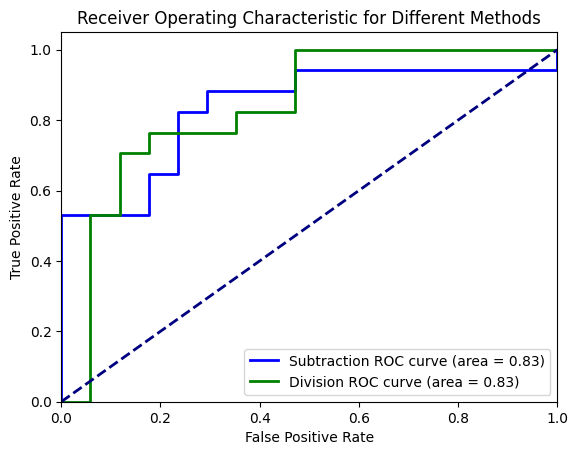

In [107]:
# Assuming 'infected_data' and 'filtered_data' are already defined
#test_dataset = Dataset(data)

true_labels_div = [1 if (label == 1 or label == 2) else 0 for _, label in train_annotated]  # Assuming label 1 is for infected
true_labels_subs = [1 if label == -1 else 0 for _, label in train_annotated]  # division classifies inversely
scores_subs = []
scores_div = []

# Predict scores for each method
for pacient in annotated_dataset:
    predicted_labels_subs = []
    predicted_labels_div = []
    for img in pacient[0]:
        img = to_img(img)
        img = img.to(device)
        output = model(img)

        img = imgback2normal(img)
        output = imgback2normal(output)

        
        Fr_subs = red_percentage(img) - red_percentage(output)
        Fr_div = (red_percentage(output) + 0.01) / (red_percentage(img) + 0.01)

        if Fr_subs >= 0.1953125:
            predicted_labels_subs.append(1)
            
        else:
            predicted_labels_subs.append(-1)
        
        if Fr_div >= 0.05357031990197122:
            predicted_labels_div.append(-1)
            
        else:
            predicted_labels_div.append(1)

    sub_healthy = [1 for i in predicted_labels_subs if i == -1]
    sub_ratio = sum(sub_healthy)/len(predicted_labels_subs)
    div_healthy = [1 for i in predicted_labels_subs if i == 1]
    div_ratio = sum(div_healthy)/len(predicted_labels_div)

    scores_subs.append(sub_ratio)
    scores_div.append(div_ratio)

# Calculate ROC curves and AUC scores
fpr_subs, tpr_subs, thresholds_subs = roc_curve(true_labels_subs, scores_subs)
roc_auc_subs = roc_auc_score(true_labels_subs, scores_subs)

fpr_div, tpr_div, thresholds_div = roc_curve(true_labels_div, scores_div)
roc_auc_div = roc_auc_score(true_labels_div, scores_div)
    
# Plot ROC curves
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

Optimal threshold for subtraction method: 0.8308433734939759
Optimal threshold for division method: 0.18361581920903955


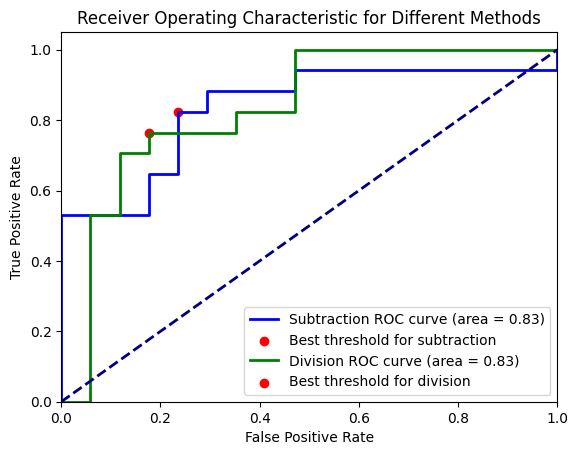

In [108]:
# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner (0,1)
distances_subs = (1-tpr_subs)**2 + fpr_subs**2

min_distance_subs = np.min(distances_subs)  # The minimum distance
optimal_idx_subs = np.argmin(distances_subs)  # The index of the optimal threshold

# Get the optimal threshold value
optimal_threshold_subs = thresholds_subs[optimal_idx_subs]

# Similarly for the 'div' method
distances_div = (1-tpr_div)**2 + fpr_div**2
min_distance_div = np.min(distances_div)
optimal_idx_div = np.argmin(distances_div)

optimal_threshold_div = thresholds_div[optimal_idx_div]

# Now, you have the optimal thresholds for both methods
print(f"Optimal threshold for subtraction method: {optimal_threshold_subs}")
print(f"Optimal threshold for division method: {optimal_threshold_div}")

# And if you want to plot these points on the ROC curve
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.scatter(fpr_subs[optimal_idx_subs], tpr_subs[optimal_idx_subs], marker='o', color='red', label='Best threshold for subtraction')

plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')
plt.scatter(fpr_div[optimal_idx_div], tpr_div[optimal_idx_div], marker='o', color='red', label='Best threshold for division')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

division


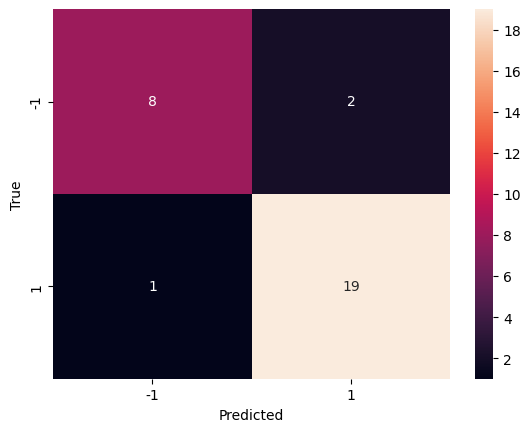



substraction


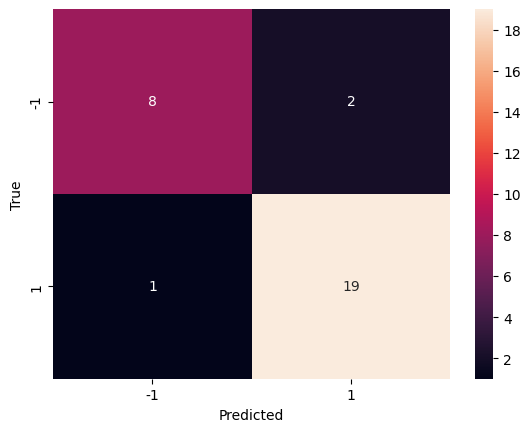

,Precision,Recall,F1,Accuracy
Division,[0.9047619047619048],[0.95],[0.9268292682926829],[0.9]
Substraction,[0.9047619047619048],[0.95],[0.9268292682926829],[0.9]


In [109]:
predicted_pac_subs = []
predicted_pac_div = []

for pacient in test_dataset:
    predicted_labels_subs = []
    predicted_labels_div = []
    for img in pacient[0]:
        img = to_img(img)
        img = img.to(device)
        output = model(img)

        img = imgback2normal(img)
        output = imgback2normal(output)

        
        Fr_subs = red_percentage(img) - red_percentage(output)
        Fr_div = (red_percentage(output) + 0.01) / (red_percentage(img) + 0.01)

        if Fr_subs >= 0.1953125:
            predicted_labels_subs.append(1)
            
        else:
            predicted_labels_subs.append(-1)
        
        if Fr_div >= 0.05357031990197122:
            predicted_labels_div.append(-1)
            
        else:
            predicted_labels_div.append(1)

    sub_healthy = [1 for i in predicted_labels_subs if i == -1]
    sub_ratio = sum(sub_healthy)/len(predicted_labels_subs)
    div_healthy = [1 for i in predicted_labels_subs if i == 1]
    div_ratio = sum(div_healthy)/len(predicted_labels_div)

    if sub_ratio >= optimal_threshold_subs:
        predicted_pac_subs.append(-1)
            
    else:
        predicted_pac_subs.append(1)
        
    if div_ratio >= optimal_threshold_div:
        predicted_pac_div.append(1)
            
    else:
        predicted_pac_div.append(-1)


predicted_labels = {'division': predicted_pac_div, 'substraction': predicted_pac_subs}

y_true = [1 if (label == 1 or label == 2) else -1 for _, label in test_annotated]  # Assuming label 1 is for infected

all_metrics = []
for key, value in predicted_labels.items():
    print(key)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, value, average='binary')
    accuracy = accuracy_score(y_true, value)
    metrics = {'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Accuracy': [accuracy]}
    all_metrics.append(metrics)

    #compute confusion matrix
    cm = confusion_matrix(y_true, value)

    #plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('\n')

#show precision, recall, f1 and accuracy in a table
metrics_table = pd.DataFrame(data=all_metrics, index=['Division', 'Substraction'])

metrics_table.head()

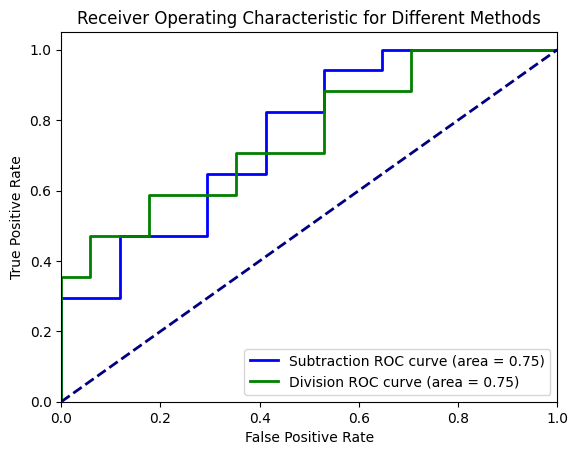

In [110]:
true_labels_div = [1 if (label != 2) else 0 for _, label in train_low_high]  # Assuming label 1 is for infected
true_labels_subs = [1 if label == 2 else 0 for _, label in train_low_high]  # division classifies inversely
scores_subs = []
scores_div = []

# Predict scores for each method
for pacient in train_low_high_dataset:
    predicted_labels_subs = []
    predicted_labels_div = []
    for img in pacient[0]:
        img = to_img(img)
        img = img.to(device)
        output = model(img)

        img = imgback2normal(img)
        output = imgback2normal(output)

        
        Fr_subs = red_percentage(img) - red_percentage(output)
        Fr_div = (red_percentage(output) + 0.01) / (red_percentage(img) + 0.01)

        if Fr_subs >= 0.1953125:
            predicted_labels_subs.append(-1)
            
        else:
            predicted_labels_subs.append(1)
        
        if Fr_div >= 0.05357031990197122:
            predicted_labels_div.append(1)
            
        else:
            predicted_labels_div.append(-1)

    sub_healthy = [1 for i in predicted_labels_subs if i == -1]
    sub_ratio = sum(sub_healthy)/len(predicted_labels_subs)
    div_healthy = [1 for i in predicted_labels_subs if i == 1]
    div_ratio = sum(div_healthy)/len(predicted_labels_div)

    scores_subs.append(sub_ratio)
    scores_div.append(div_ratio)

# Calculate ROC curves and AUC scores
fpr_subs, tpr_subs, thresholds_subs = roc_curve(true_labels_subs, scores_subs)
roc_auc_subs = roc_auc_score(true_labels_subs, scores_subs)

fpr_div, tpr_div, thresholds_div = roc_curve(true_labels_div, scores_div)
roc_auc_div = roc_auc_score(true_labels_div, scores_div)
    
# Plot ROC curves
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

Optimal threshold for subtraction method: 0.29180771834800273
Optimal threshold for division method: 0.7369077306733167


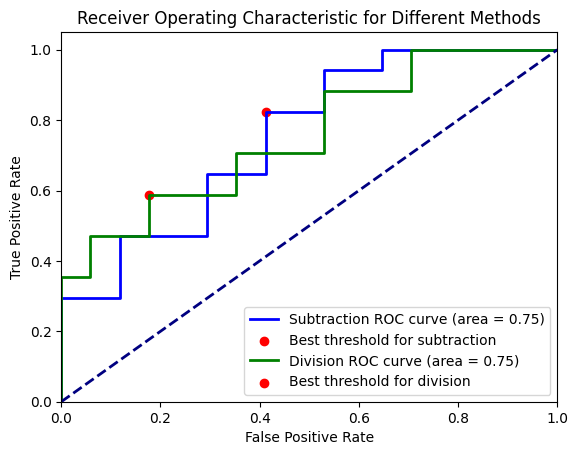

In [111]:
# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner (0,1)
distances_subs = (1-tpr_subs)**2 + fpr_subs**2

min_distance_subs = np.min(distances_subs)  # The minimum distance
optimal_idx_subs = np.argmin(distances_subs)  # The index of the optimal threshold

# Get the optimal threshold value
optimal_threshold_subs = thresholds_subs[optimal_idx_subs]

# Similarly for the 'div' method
distances_div = (1-tpr_div)**2 + fpr_div**2
min_distance_div = np.min(distances_div)
optimal_idx_div = np.argmin(distances_div)

optimal_threshold_div = thresholds_div[optimal_idx_div]

# Now, you have the optimal thresholds for both methods
print(f"Optimal threshold for subtraction method: {optimal_threshold_subs}")
print(f"Optimal threshold for division method: {optimal_threshold_div}")

# And if you want to plot these points on the ROC curve
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.scatter(fpr_subs[optimal_idx_subs], tpr_subs[optimal_idx_subs], marker='o', color='red', label='Best threshold for subtraction')

plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')
plt.scatter(fpr_div[optimal_idx_div], tpr_div[optimal_idx_div], marker='o', color='red', label='Best threshold for division')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

division


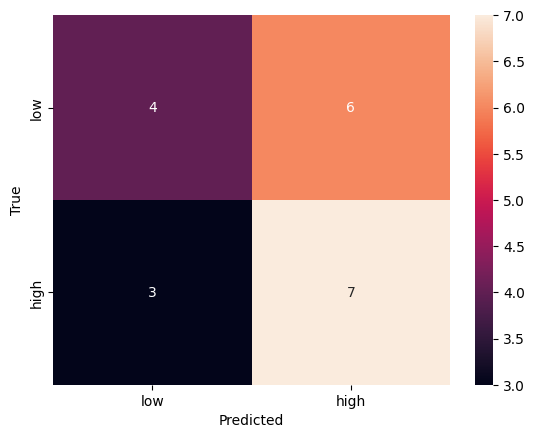



substraction


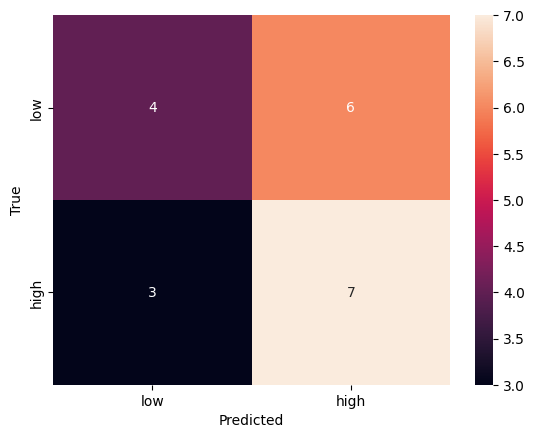

,Precision,Recall,F1,Accuracy
Division,[0.5714285714285714],[0.4],[0.47058823529411764],[0.55]
Substraction,[0.5714285714285714],[0.4],[0.47058823529411764],[0.55]


In [112]:
predicted_lh_subs = []
predicted_lh_div = []

# Predict scores for each method
for pacient in test_low_high_dataset:
    predicted_labels_subs = []
    predicted_labels_div = []
    for img in pacient[0]:
        img = to_img(img)
        img = img.to(device)
        output = model(img)

        img = imgback2normal(img)
        output = imgback2normal(output)

        
        Fr_subs = red_percentage(img) - red_percentage(output)
        Fr_div = (red_percentage(output) + 0.01) / (red_percentage(img) + 0.01)

        if Fr_subs >= 0.1953125:
            predicted_labels_subs.append(-1)
            
        else:
            predicted_labels_subs.append(1)
        
        if Fr_div >=0.05357031990197122:
            predicted_labels_div.append(1)
            
        else:
            predicted_labels_div.append(-1)

    sub_healthy = [1 for i in predicted_labels_subs if i == -1]
    sub_ratio = sum(sub_healthy)/len(predicted_labels_subs)
    div_healthy = [1 for i in predicted_labels_subs if i == 1]
    div_ratio = sum(div_healthy)/len(predicted_labels_div)

    if sub_ratio >= optimal_threshold_subs:
        predicted_lh_subs.append(2)
            
    else:
        predicted_lh_subs.append(1)
        
    if div_ratio >= optimal_threshold_div:
        predicted_lh_div.append(1)
            
    else:
        predicted_lh_div.append(2)


predicted_labels = {'division': predicted_lh_div, 'substraction': predicted_lh_subs}

y_true = [label for _, label in test_low_high]  # Assuming label 1 is for high

all_metrics = []
for key, value in predicted_labels.items():
    print(key)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, value, average='binary')
    accuracy = accuracy_score(y_true, value)
    metrics = {'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Accuracy': [accuracy]}
    all_metrics.append(metrics)

    #compute confusion matrix
    cm = confusion_matrix(y_true, value)

    #plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['low', 'high'], yticklabels=['low', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('\n')

#show precision, recall, f1 and accuracy in a table
metrics_table = pd.DataFrame(data=all_metrics, index=['Division', 'Substraction'])

metrics_table.head()

## VGG ROC

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load the pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True, weights= torch.load('Vgg16.pth',  map_location=torch.device('cpu')))
# Modify the last fully connected layer to output 1 class
vgg16.classifier[-1] = nn.Linear(4096, 2)

# Set the model to evaluation mode
vgg16.eval()

# Print the model architecture
print(vgg16)

cuda


/fhome/gia04/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [83]:
true_labels = [1 if (label == 1 or label == 2) else 0 for _, label in train_annotated]  # Assuming label 1 is for infected
scores = []


# Predict scores for each method
for pacient in annotated_dataset:
    predicted_labels = []
    
    for img in pacient[0]:
        img = to_img(img)
        
        output = vgg16(img)

        predicted_label = output.squeeze()

        predicted_label = torch.sigmoid(predicted_label)
    
        #convert the predicted label to numpy
        predicted_label = predicted_label.detach().numpy()

        #The predicted label is the index of the maximum value in the predicted_label array
        predicted_label = np.argmax(predicted_label)
        if predicted_label == 0:
            predicted_label = -1
        predicted_labels.append(predicted_label)

    healthy = [1 for i in predicted_labels if i == -1]
    ratio = sum(healthy)/len(predicted_labels)


    scores.append(ratio)

# Calculate ROC curves and AUC scores
fpr, tprs, thresholds = roc_curve(true_labels, scores)
roc_auc = roc_auc_score(true_labels, scores)
    
# Plot ROC curves
plt.figure()

plt.plot(fpr, tprs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [40, 34]